In [39]:
import numpy as np
import pandas as pd
import os
import glob
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import sys
from osgeo import gdal
import pickle

In [40]:
# file = "/mnt/poseidon/remotesensing/arctic/data/rasters/model_results_tiled/GRIDCELL_3100_graminoid.tif"
# opts = gdal.WarpOptions(format='GTiff', dstSRS='EPSG:4326')
# gdal.Warp(file, file, options=opts)

In [41]:
sys.version

'3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:34:09) [GCC 12.3.0]'

In [42]:
xr.__version__

'2023.10.1'

In [43]:
# General Params
BASE = '/mnt/poseidon/remotesensing/arctic/data'
OUT_DIR = f'{BASE}/rasters/model_results_tiled_test05'
DATA_DIR = f'{BASE}/rasters'
CELL_LIST = list(range(3658,3659))
TEST_CELL_IDX = 0
TEST_CELL = CELL_LIST[TEST_CELL_IDX]
REF_RAST = f'{DATA_DIR}/s2_sr_tiled/ak_arctic_summer/B11/2019-06-01_to_2019-08-31/GRIDCELL_{TEST_CELL}.tif'
MODEL = f'{BASE}/training/Test_05/results/ModelTuning_FeatureImportance'
PFT_LIST = ['deciduous shrub', 'evergreen shrub', 'forb', 'graminoid', 'litter', 'non-vascular']

# Sensor-specific Params
S2_DIR = f'{DATA_DIR}/s2_sr_tiled/ak_arctic_summer/*/*'
S1_DIR = f'{DATA_DIR}/s1_grd_tiled'
DEM_DIR = f'{DATA_DIR}/acrtic_dem_tiled'

In [44]:
print('Number of gridcells to work on:', len(CELL_LIST))

Number of gridcells to work on: 1


## Definitions

In [45]:
def gridcell_rast_list(cell_num_list, directory):# read rasters with glob
    
    cell_list = []
    for cellnum in cell_num_list:
        cell_band_paths = sorted(glob.glob(f'{directory}/GRIDCELL_{cellnum}*'))
        cell_list.append(cell_band_paths)
    return cell_list

In [46]:
# function to stack sensor bands for one gridcell
# will need to loop through each sensor and gridcell
def stack_bands(sensor, cell_num,
                resample_bands, ref_rast, scale_factor=None):
    
    """
    Creates an xarray with each band recorded as a variable.
    sensor         : [str] sensor source of data (s2_sr, s1_grd, or dem)
    cell_num       : [int] gridcell number to analyze
    resample_bands : [list] bands that need to be rescaled to 20-meters
    ref_rast       : [xr.Dataset] raster used as the model resolution/crs
    scale_factor   : [float or int] number multiplied to rescale data
    Returns an xr.Dataset with x,y,band dimensions for one gridcell with 
    each band as a data variable that matches the resolution/scale of the
    reference raster.
    """

    raster_bands = []
    for band_path in cell_num:

        # get band name from file path
        if sensor == 's2_sr':
            b_name = band_path.split('/')[-3]
        elif sensor == 'dem':
            b_name = band_path.split('/')[-1]
            b_name = b_name.split('.')[0]
            b_name = b_name.split('_')[-1]
        elif sensor == 's1_grd':
            b_name = band_path.split('/')[-1]
            print(b_name)
            b_name = b_name.split('.')[0]
            b_name = b_name.split('_')[-1]
        else:
            print('Incorrect sensor choice. Try dem, s2_sr, or s1_grd.')
        print(f'Creating raster for {b_name}...')
        
        # open raster in xarray
        raster = rxr.open_rasterio(band_path)
        raster.name = b_name
        print(raster.sizes, raster.dims)
        # raster.plot()
        # plt.show()
        
        # resample and rescale if necessary
        print(f'Rescaling {b_name}...')
        raster = raster.rio.reproject_match(ref_rast)
        if scale_factor is not None:
            raster = raster * scale_factor
            
        # append to band list
        raster_bands.append(raster)

    merged = xr.merge(raster_bands)
    # drop pixel if any band is NA
    merged = merged.dropna(dim='band', how='any')
    return merged

In [47]:
# plot stacked raster and reference raster
def plot_rasters(raster, ref_raster, 
                 vmin, vmax, rvmin, rvmax):
    
    # plot to visualize if reference raster and adjusted
    # look visually correct
    fig, axes = plt.subplots(ncols=2, figsize=(12,4))
    raster.plot(ax=axes[0], vmin=vmin, vmax=vmax)
    ref_raster.plot(ax=axes[1], vmin=rvmin, vmax=rvmax)
    plt.draw()

In [48]:
def calc_veg_idx_s2(xrd):
    
    """
    Creates new data attributes for an s2_sr xr.Dataset with bands
    B2, B3, B4, B5, B6, B8, B8A, B11, and B12. Second step after 
    stack_bands. S2_sr data must be scaled from 0 to 1; can set
    scale factor in stack_bands function if necessary.
    xrd : [xr.Dataset] s2_sr xarray dataset
    Returns: xarray dataset with new vegetation indices
    """
    
    xrd = xrd.assign(ndwi1 = lambda x: (x.nir - x.swir1)/(x.nir + x.swir2))
    xrd = xrd.assign(ndwi2 = lambda x: (x.nir - x.swir2)/(x.nir + x.swir2))
    xrd = xrd.assign(msavi = lambda x: (2*x.nir + 1 -  ((2*x.nir + 1)**2 - 8*(x.nir - x.red))**0.5) * 0.5)
    xrd = xrd.assign(vari = lambda x: (x.green - x.red)/(x.green + x.red - x.blue))
    xrd = xrd.assign(rvi = lambda x: x.nir/x.red)
    xrd = xrd.assign(osavi = lambda x: 1.16 * (x.nir - x.red)/(x.nir + x.red + 0.16))
    xrd = xrd.assign(tgi = lambda x: (120 * (x.red - x.blue) - 190 * (x.red - x.green))*0.5)
    xrd = xrd.assign(gli = lambda x: (2 * x.green - x.red - x.blue)/(2 * x.green + x.red + x.blue))
    xrd = xrd.assign(ngrdi = lambda x: (x.green - x.red)/(x.green + x.red))
    xrd = xrd.assign(ci_g = lambda x: x.nir/x.green - 1)
    xrd = xrd.assign(gNDVI = lambda x: (x.nir - x.green)/(x.nir + x.green))
    xrd = xrd.assign(cvi = lambda x: (x.nir * x.red)/(x.green ** 2))
    xrd = xrd.assign(mtvi2 = lambda x: 1.5*(1.2*(x.nir - x.green) - 2.5*(x.red - x.green))/(((2*x.nir + 1)**2 - (6*x.nir - 5*(x.red**0.5))-0.5)**0.5))
    xrd = xrd.assign(brightness = lambda x: 0.3037 * x.blue +0.2793 * x.green +0.4743 * x.red +0.5585 * x.nir +0.5082 * x.swir1 + 0.1863 * x.swir2)
    xrd = xrd.assign(greenness = lambda x: 0.7243 * x.nir +0.0840 * x.swir1 - 0.2848 * x.blue - 0.2435 * x.green - 0.5436 * x.red - 0.1800 * x.swir2)
    xrd = xrd.assign(wetness = lambda x: 0.1509 * x.blue+0.1973* x.green+0.3279*x.red+0.3406*x.nir-0.7112*x.swir1 - 0.4572*x.swir2)
    xrd = xrd.assign(tcari = lambda x: 3 * ((x.redEdge1 - x.red)-0.2 * (x.redEdge1 - x.green)*(x.redEdge1/x.red)))
    xrd = xrd.assign(tci = lambda x: 1.2 * (x.redEdge1 - x.green)- 1.5 * (x.red - x.green)*((x.redEdge1/x.red)**0.5))
    xrd = xrd.assign(nari = lambda x: (1/x.green - 1/x.redEdge1)/(1/x.green + 1/x.redEdge1))

    return xrd

## Prepare Sentinel 2 Data

In [49]:
rast_list = gridcell_rast_list(CELL_LIST, S2_DIR)
print('Rasters to stack for gridcell:', rast_list[TEST_CELL_IDX])

Rasters to stack for gridcell: ['/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B11/2019-06-01_to_2019-08-31/GRIDCELL_3658.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B12/2019-06-01_to_2019-08-31/GRIDCELL_3658.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B2/2019-06-01_to_2019-08-31/GRIDCELL_3658.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B3/2019-06-01_to_2019-08-31/GRIDCELL_3658.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B4/2019-06-01_to_2019-08-31/GRIDCELL_3658.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B5/2019-06-01_to_2019-08-31/GRIDCELL_3658.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B6/2019-06-01_to_2019-08-31/GRIDCELL_3658.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B7/201

In [50]:
# create 20-m raster
scale_factor = 0.0001
reference_raster = rxr.open_rasterio(REF_RAST) * scale_factor
rescale_bands = ['B2', 'B3', 'B4', 'B8']
s2_stacked_raster = stack_bands('s2_sr', rast_list[TEST_CELL_IDX], 
                                rescale_bands, reference_raster, scale_factor)

Creating raster for B11...
Frozen({'band': 1, 'y': 900, 'x': 900}) ('band', 'y', 'x')
Rescaling B11...
Creating raster for B12...
Frozen({'band': 1, 'y': 900, 'x': 900}) ('band', 'y', 'x')
Rescaling B12...
Creating raster for B2...
Frozen({'band': 1, 'y': 1800, 'x': 1800}) ('band', 'y', 'x')
Rescaling B2...
Creating raster for B3...
Frozen({'band': 1, 'y': 1800, 'x': 1800}) ('band', 'y', 'x')
Rescaling B3...
Creating raster for B4...
Frozen({'band': 1, 'y': 1800, 'x': 1800}) ('band', 'y', 'x')
Rescaling B4...
Creating raster for B5...
Frozen({'band': 1, 'y': 900, 'x': 900}) ('band', 'y', 'x')
Rescaling B5...
Creating raster for B6...
Frozen({'band': 1, 'y': 900, 'x': 900}) ('band', 'y', 'x')
Rescaling B6...
Creating raster for B7...
Frozen({'band': 1, 'y': 1800, 'x': 1800}) ('band', 'y', 'x')
Rescaling B7...
Creating raster for B8...
Frozen({'band': 1, 'y': 1800, 'x': 1800}) ('band', 'y', 'x')
Rescaling B8...
Creating raster for B8A...
Frozen({'band': 1, 'y': 900, 'x': 900}) ('band', '

In [51]:
# rename bands to something legible
s2_stacked_raster = s2_stacked_raster.rename({'B2':'blue', 
                                              'B3':'green', 
                                              'B4':'red', 
                                              'B5':'redEdge1', 
                                              'B6':'redEdge2', 
                                              'B7':'redEdge3', 
                                              'B8A':'redEdge4', 
                                              'B8':'nir',
                                              'B11':'swir1',
                                              'B12':'swir2'})

In [52]:
# calculate vegetation indices
stacked_raster_veg = calc_veg_idx_s2(s2_stacked_raster)
stacked_raster_veg

<xarray.Dataset>
Dimensions:      (band: 1, x: 900, y: 900)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -150.4 -150.4 -150.4 ... -150.2 -150.2 -150.2
  * y            (y) float64 69.53 69.53 69.53 69.53 ... 69.37 69.37 69.37 69.37
Data variables: (12/29)
    swir1        (band, y, x) float64 0.2823 0.2771 0.2771 ... 0.07877 0.07877
    swir2        (band, y, x) float64 0.1653 0.1612 0.1612 ... 0.04732 0.04732
    blue         (band, y, x) float64 0.0484 0.04835 0.05045 ... 0.02661 0.01731
    green        (band, y, x) float64 0.0708 0.07075 0.0708 ... 0.03047 0.02042
    red          (band, y, x) float64 0.09965 0.0926 0.0889 ... 0.02711 0.01701
    redEdge1     (band, y, x) float64 0.1327 0.1291 0.1291 ... 0.0413 0.0413
    ...           ...
    brightness   (band, y, x) float64 0.3926 0.3883 0.3843 ... 0.1328 0.09189
    greenness    (band, y, x) float64 0.08592 0.09336 0.09092 ... 0.03901 0.0101
    wetness      (band, y, x) float64 -0.1391 -0.1343 ... -0.02552 -0.05079
    tcari        (band, y, x) float64 0.04969 0.06069 0.0698 ... 0.03269 0.04245
    tci          (band, y, x) float64 0.02434 0.03132 ... 0.01923 0.03303
    nari         (band, y, x) float64 0.3042 0.292 0.2916 ... 0.1509 0.3384

## Prepare Sentinel 1 data

In [53]:
s1_rast_list = gridcell_rast_list(CELL_LIST, S1_DIR)
print('Rasters to stack for gridcell:', s1_rast_list[TEST_CELL_IDX])

Rasters to stack for gridcell: ['/mnt/poseidon/remotesensing/arctic/data/rasters/s1_grd_tiled/GRIDCELL_3658_VH.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s1_grd_tiled/GRIDCELL_3658_VV.tif']


In [54]:
# create 20-m raster
scale_factor = 0.0001
reference_raster = rxr.open_rasterio(REF_RAST) * scale_factor
rescale_bands = ['VV', 'VH']
s1_stacked_raster = stack_bands('s1_grd', s1_rast_list[TEST_CELL_IDX], 
                                rescale_bands, reference_raster)

GRIDCELL_3658_VH.tif
Creating raster for VH...
Frozen({'band': 1, 'y': 1800, 'x': 1800}) ('band', 'y', 'x')
Rescaling VH...
GRIDCELL_3658_VV.tif
Creating raster for VV...
Frozen({'band': 1, 'y': 1800, 'x': 1800}) ('band', 'y', 'x')
Rescaling VV...


In [55]:
s1_stacked_raster

<xarray.Dataset>
Dimensions:      (band: 1, x: 900, y: 900)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -150.4 -150.4 -150.4 ... -150.2 -150.2 -150.2
  * y            (y) float64 69.53 69.53 69.53 69.53 ... 69.37 69.37 69.37 69.37
Data variables:
    VH           (band, y, x) float32 0.0007611 0.0007918 ... 0.000277 0.0005266
    VV           (band, y, x) float32 0.002222 0.001928 ... 0.001257 0.001921
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0.0

## Prepare Arctic DEM Data

In [56]:
dem_rast_list = gridcell_rast_list(CELL_LIST, DEM_DIR)
print('Rasters to stack for gridcell:', dem_rast_list[TEST_CELL_IDX])

Rasters to stack for gridcell: ['/mnt/poseidon/remotesensing/arctic/data/rasters/acrtic_dem_tiled/GRIDCELL_3658_dem.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/acrtic_dem_tiled/GRIDCELL_3658_dem_aspect.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/acrtic_dem_tiled/GRIDCELL_3658_dem_hillshade.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/acrtic_dem_tiled/GRIDCELL_3658_dem_slope.tif']


In [57]:
# create 20-m raster
scale_factor = 0.0001
reference_raster = rxr.open_rasterio(REF_RAST) * scale_factor
rescale_bands = ['aspect', 'dem', 'hillshade', 'slope']
dem_stacked_raster = stack_bands('dem', dem_rast_list[TEST_CELL_IDX], 
                                 rescale_bands, reference_raster)
dem_stacked_raster = dem_stacked_raster.rename({'dem':'elevation'})

Creating raster for dem...
Frozen({'band': 1, 'y': 925, 'x': 925}) ('band', 'y', 'x')
Rescaling dem...
Creating raster for aspect...
Frozen({'band': 1, 'y': 943, 'x': 942}) ('band', 'y', 'x')
Rescaling aspect...
Creating raster for hillshade...
Frozen({'band': 1, 'y': 943, 'x': 942}) ('band', 'y', 'x')
Rescaling hillshade...
Creating raster for slope...
Frozen({'band': 1, 'y': 943, 'x': 942}) ('band', 'y', 'x')
Rescaling slope...


In [58]:
rescale_bands2 = ['aspect', 'elevation', 'hillshade', 'slope']
dem_stacked_raster = dem_stacked_raster.where(dem_stacked_raster[rescale_bands2] != -9999., 0.)
dem_stacked_raster

<xarray.Dataset>
Dimensions:      (band: 1, y: 900, x: 900)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -150.4 -150.4 -150.4 ... -150.2 -150.2 -150.2
  * y            (y) float64 69.53 69.53 69.53 69.53 ... 69.37 69.37 69.37 69.37
Data variables:
    elevation    (band, y, x) float32 118.8 118.9 118.9 ... 170.7 170.7 170.7
    aspect       (band, y, x) float32 140.9 94.55 94.55 ... 37.5 109.3 109.3
    hillshade    (band, y, x) float64 180.0 179.0 179.0 ... 180.0 179.0 179.0
    slope        (band, y, x) float32 0.3819 0.6342 0.6342 ... 0.676 0.676
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -9999.0

## Combine and Prep for Modelling

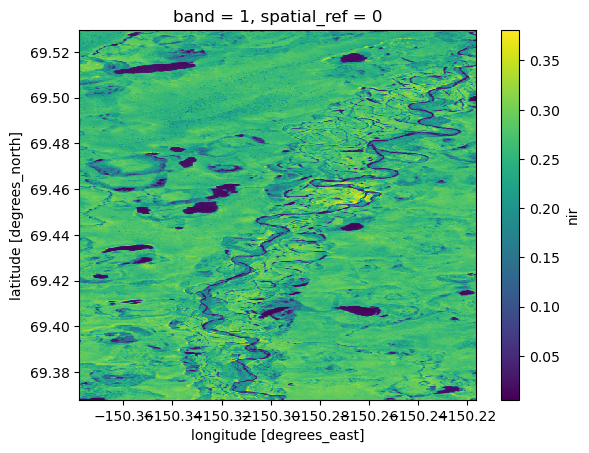

In [59]:
s2_stacked_raster.nir.plot()

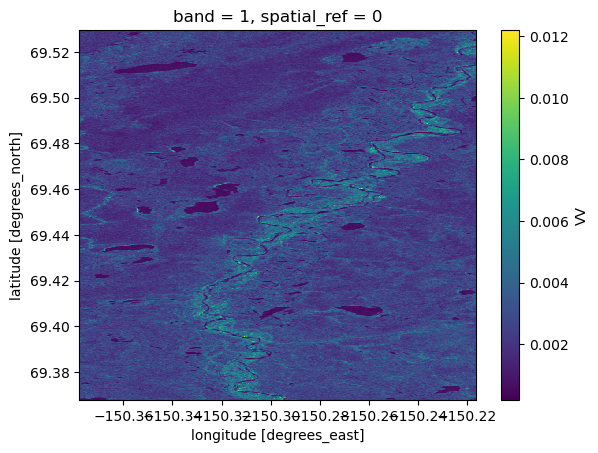

In [60]:
s1_stacked_raster.VV.plot()

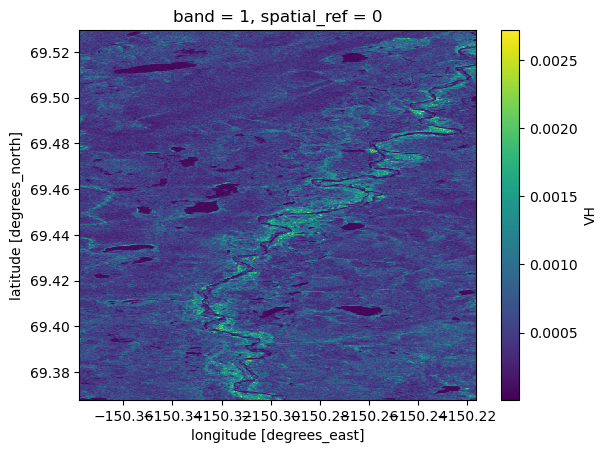

In [61]:
s1_stacked_raster.VH.plot()

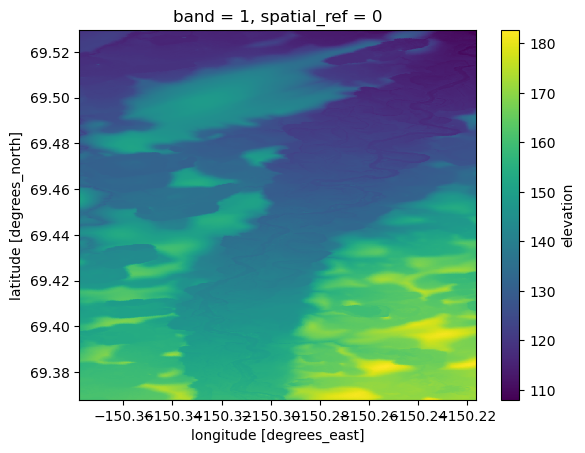

In [62]:
dem_stacked_raster.elevation.plot()

In [63]:
# make sure pandas df features are in the right order
stacked_raster = xr.merge([stacked_raster_veg, s1_stacked_raster, dem_stacked_raster])

In [64]:
stacked_raster

<xarray.Dataset>
Dimensions:      (band: 1, x: 900, y: 900)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -150.4 -150.4 -150.4 ... -150.2 -150.2 -150.2
  * y            (y) float64 69.53 69.53 69.53 69.53 ... 69.37 69.37 69.37 69.37
Data variables: (12/35)
    swir1        (band, y, x) float64 0.2823 0.2771 0.2771 ... 0.07877 0.07877
    swir2        (band, y, x) float64 0.1653 0.1612 0.1612 ... 0.04732 0.04732
    blue         (band, y, x) float64 0.0484 0.04835 0.05045 ... 0.02661 0.01731
    green        (band, y, x) float64 0.0708 0.07075 0.0708 ... 0.03047 0.02042
    red          (band, y, x) float64 0.09965 0.0926 0.0889 ... 0.02711 0.01701
    redEdge1     (band, y, x) float64 0.1327 0.1291 0.1291 ... 0.0413 0.0413
    ...           ...
    VH           (band, y, x) float32 0.0007611 0.0007918 ... 0.000277 0.0005266
    VV           (band, y, x) float32 0.002222 0.001928 ... 0.001257 0.001921
    elevation    (band, y, x) float32 118.8 118.9 118.9 ... 170.7 170.7 170.7
    aspect       (band, y, x) float32 140.9 94.55 94.55 ... 37.5 109.3 109.3
    hillshade    (band, y, x) float64 180.0 179.0 179.0 ... 180.0 179.0 179.0
    slope        (band, y, x) float32 0.3819 0.6342 0.6342 ... 0.676 0.676

In [65]:
df = stacked_raster.to_dataframe()
coords = df.reset_index()
coords = coords[['x', 'y']]
coords

x          y
0      -150.377889  69.529513
1      -150.377889  69.529333
2      -150.377889  69.529154
3      -150.377889  69.528974
4      -150.377889  69.528795
...            ...        ...
809995 -150.216372  69.368715
809996 -150.216372  69.368535
809997 -150.216372  69.368355
809998 -150.216372  69.368176
809999 -150.216372  69.367996

[810000 rows x 2 columns]

In [66]:
df = df.droplevel([1, 2]).reset_index(drop=True)
df = df.iloc[:,1:]
df = df.astype("float32")
df

swir1     swir2      blue     green       red  redEdge1  redEdge2  \
0       0.282250  0.165350  0.048400  0.070800  0.099650  0.132700  0.186700   
1       0.286700  0.167500  0.050150  0.071850  0.103000  0.136150  0.191550   
2       0.286650  0.163350  0.049800  0.072500  0.102350  0.136400  0.194750   
3       0.293150  0.172750  0.053450  0.077250  0.113100  0.141800  0.199350   
4       0.297850  0.175150  0.051550  0.073750  0.101450  0.139900  0.195350   
...          ...       ...       ...       ...       ...       ...       ...   
809995  0.198920  0.113733  0.039180  0.062544  0.068617  0.107183  0.253983   
809996  0.194400  0.116350  0.037443  0.052623  0.056100  0.108350  0.215175   
809997  0.144567  0.083600  0.033767  0.046700  0.047583  0.081800  0.136100   
809998  0.090714  0.047817  0.020363  0.024091  0.020786  0.046357  0.072700   
809999  0.078775  0.047317  0.017313  0.020417  0.017009  0.041302  0.056625   

        redEdge3       nir  redEdge4  ...   wetness     tcari       tci  \
0       0.212950  0.244600  0.250800  ... -0.139076  0.049692  0.024342   
1       0.212450  0.250800  0.256500  ... -0.139542  0.048453  0.023440   
2       0.218050  0.247200  0.251300  ... -0.138973  0.051055  0.024991   
3       0.218050  0.250800  0.256400  ... -0.141655  0.037542  0.017247   
4       0.215500  0.251100  0.255950  ... -0.150790  0.060617  0.030587   
...          ...       ...       ...  ...       ...       ...       ...   
809995  0.239975  0.236400  0.312908  ... -0.072201  0.073863  0.042183   
809996  0.239975  0.206600  0.260287  ... -0.086657  0.092172  0.059624   
809997  0.155275  0.149733  0.183871  ... -0.060127  0.066446  0.040383   
809998  0.081560  0.056067  0.084250  ... -0.052640  0.046919  0.034123   
809999  0.069037  0.043000  0.083312  ... -0.050794  0.042450  0.033027   

            nari        VH        VV   elevation      aspect  hillshade  \
0       0.304177  0.000761  0.002222  118.812500  140.946869      180.0   
1       0.309135  0.000535  0.002539  118.968750  119.054604      180.0   
2       0.305888  0.000427  0.002427  119.031250  138.366455      180.0   
3       0.294682  0.000385  0.002570  119.203125  118.009178      180.0   
4       0.309619  0.000543  0.002396  119.257812   95.527542      180.0   
...          ...       ...       ...         ...         ...        ...   
809995  0.263003  0.000853  0.003630  171.546875  263.242920      184.0   
809996  0.346188  0.000561  0.001975  171.132812  258.690063      186.0   
809997  0.273152  0.000287  0.001856  170.554688  254.638382      182.0   
809998  0.316066  0.000232  0.001406  170.648438  168.274887      180.0   
809999  0.338395  0.000527  0.001921  170.703125  109.334808      179.0   

           slope  
0       0.381870  
1       0.172821  
2       0.404251  
3       0.297864  
4       0.174264  
...          ...  
809995  1.188694  
809996  1.739825  
809997  0.528022  
809998  0.605718  
809999  0.675958  

[810000 rows x 35 columns]

In [67]:
# find any bands that were divided by 0 and produced an inf value
bad_idx_list = df[df.values == np.inf].index.tolist()
df.drop(index=bad_idx_list, inplace=True)
coords.drop(index=bad_idx_list, inplace=True)

(810000,)
[0.21952533 0.23068633 0.21824333 ... 0.16658    0.205198   0.252604  ]


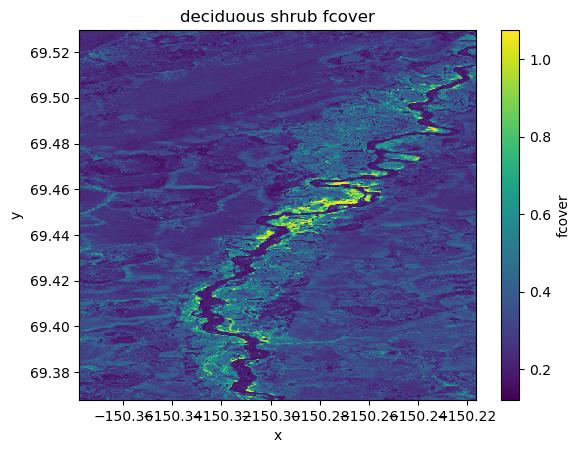

/home/6ru/anaconda3/envs/gee/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


(810000,)
[0.129698 0.130638 0.137302 ... 0.032244 0.05412  0.073884]


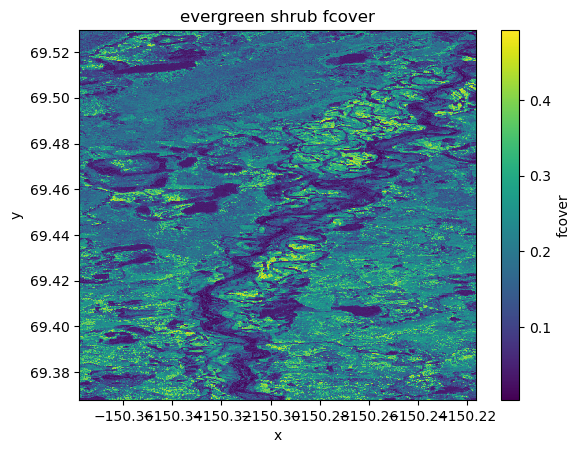

(810000,)
[0.04130567 0.04747    0.04438633 ... 0.067612   0.05917533 0.06351067]


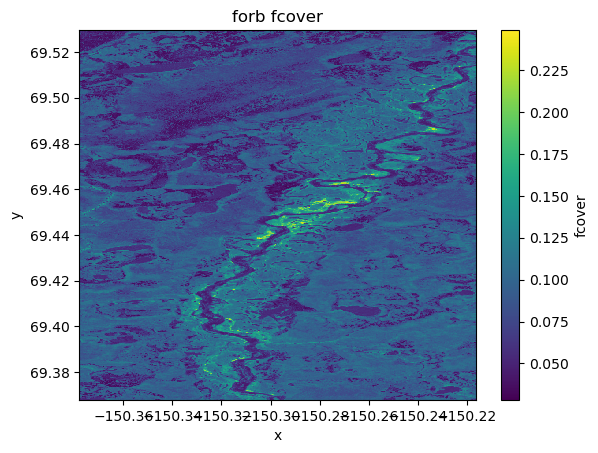

(810000,)
[0.4784405  0.46259327 0.47964092 ... 0.31394221 0.3441959  0.33937528]


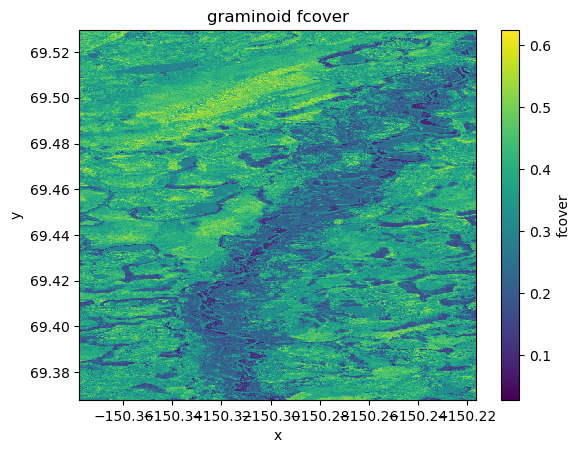

(810000,)
[0.21660533 0.21827467 0.23254    ... 0.12557339 0.10390469 0.1242117 ]


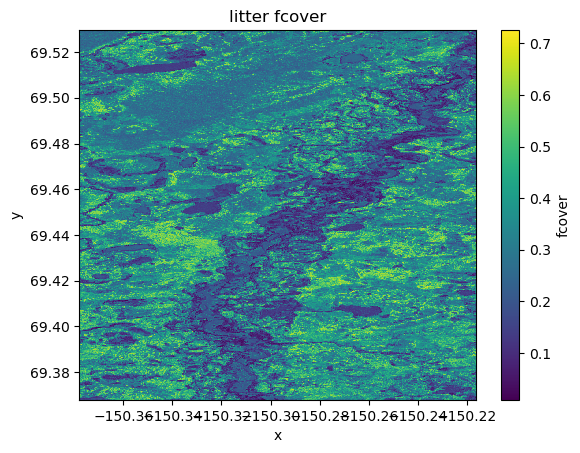

(810000,)
[0.354677   0.40946817 0.367231   ... 0.261519   0.16013    0.15665621]


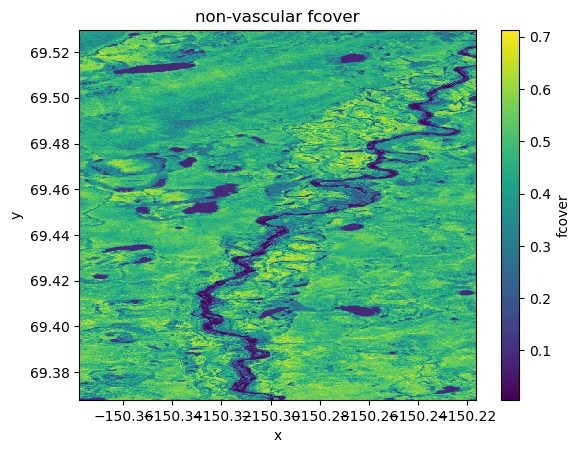

In [68]:
for PFT in PFT_LIST:
    
    # Load the pickled model from the file
    model_file_path = f'{MODEL}/tunedModel_{PFT}.pkl'
    demo_df = pd.read_csv(f'{MODEL}/FeatureDemo_non-vascular.csv', index_col=0)
    col_order = demo_df.columns.tolist()
    df = df[col_order]
    with open(model_file_path, 'rb') as model_file:
        model = pickle.load(model_file)

    # --- prediction directly used the model
    fCover = model.predict(df)   #fCover is a 1 by n 
    print(fCover.shape)
    print(fCover)
    
    # create dataframe
    results = coords.copy()
    results['fcover'] = fCover
    results['band'] = 1
    
    # create xarray and plot
    results_xr = xr.Dataset.from_dataframe(results.set_index(['band', 'y', 'x']))
    results_xr.fcover.plot()
    plt.title(f'{PFT} fcover')
    plt.show()
    
    # export tif
    PFT = PFT.replace(' ', '_')
    out_path=f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_{PFT}.tif"
    results_xr.isel(band=0).rio.to_raster(out_path)
    
    # set CRS
    opts = gdal.WarpOptions(format='GTiff', dstSRS='EPSG:4326')
    gdal.Warp(out_path, out_path, options=opts)

In [36]:
# r = stacked_raster.red.values
# g = stacked_raster.green.values
# b = stacked_raster.blue.values
# r = r.reshape(900,900)
# g = g.reshape(900,900)
# b = b.reshape(900,900)

# def adjust_lightness(color, amount=0.5):
#     import matplotlib.colors as mc
#     import colorsys
#     try:
#         c = mc.cnames[color]
#     except:
#         c = color
#     c = colorsys.rgb_to_hls(*mc.to_rgb(c))
#     return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# rgb_uint8 = (np.dstack((r,g,b)) * 255.999 + 25) .astype(np.uint8)
# plt.imshow(rgb_uint8, vmin=25, vmax=10000)

In [37]:
# stacked_raster.red.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_red.tif")
# stacked_raster.green.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_green.tif")
# stacked_raster.blue.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_blue.tif")
# stacked_raster.nir.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_nir.tif")
# stacked_raster.VV.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_VV.tif")
# stacked_raster.VH.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_VH.tif")
# stacked_raster.elevation.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_elevation.tif")
# stacked_raster.slope.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_slope.tif")
# stacked_raster.aspect.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_aspect.tif")